# Prediction of experimental band gap

This notebooks applies MODNet on the matbench experimental band gap data. It is a good example on how MODNet can be used for a composition only task, i.e. when only the stoichiometry (e.g. SiO2) is known with no structural information.

## Dependencies

In [1]:
import numpy as np
from matminer.datasets import load_dataset
from modnet.models import MODNetModel
from modnet.preprocessing import MODData
import matplotlib.pyplot as plt 
from pymatgen.core import Composition

# 1. Import dataset:
The matbench_expt_gap dataset contains measured band gaps for 4604 compositions of inorganic semiconductors from Zhuo et al., JPCL.

In [2]:
from matminer.datasets import load_dataset

df = load_dataset("matbench_expt_gap")
df["composition"] = df["composition"].map(Composition) # maps composition to a pymatgen composition object
df.head()

,composition,gap expt
0,"(Ag, Au, S)",0.00
1,"(Ag, W, Br)",0.00
2,"(Ag, Ge, Pb, S)",1.83
3,"(Ag, Ge, Pb, Se)",1.51
4,"(Ag, B, Br)",0.00


Let us have a look at the band gap distribution:

In [3]:
df.describe()

,gap expt
count,4604.000000
mean,0.975951
std,1.445034
min,0.000000
25%,0.000000
50%,0.000000
75%,1.812500
max,11.700000


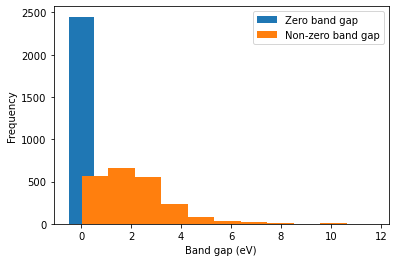

In [4]:
fig, ax = plt.subplots(facecolor="w")
ax.hist(df.where(df["gap expt"] == 0)["gap expt"], bins=1, density=False, label="Zero band gap")
ax.hist(df.where(df["gap expt"] > 0)["gap expt"], bins=11, density=False, label="Non-zero band gap")
ax.set_ylabel("Frequency")
ax.set_xlabel("Band gap (eV)")
ax.legend()

## 2. Training 
## a) create MODData
We create a MODData based on the above dataframe.

In [5]:
# This instantiates the MODData
data = MODData(
    materials=df["composition"], # you can provide composition objects to MODData
    targets=df["gap expt"], 
    target_names=["gap_expt_eV"]
)

2023-01-24 14:44:22,918 - modnet - INFO - Loaded CompositionOnlyMatminer2023Featurizer featurizer.


In [6]:
# Featurization of the moddata
# It will automatically apply composition only featurizers
# data.featurize() #this takes around 10 mins to run
# data.save("out/gap_comp.mdt")
data = MODData.load("out/gap_comp.mdt")

2023-01-24 14:44:23,032 - modnet - INFO - Loaded <modnet.preprocessing.MODData object at 0x7f9c7b613430> object, created with modnet version 0.2.0~develop


## b) Train-test split
In order to test the model on unseen data, we split the dataset in two parts: a training and testing set.

In [7]:
from sklearn.model_selection import train_test_split
split = train_test_split(range(100), test_size=0.1, random_state=1234)
train, test = data.split(split)

Important features are selected. This takes around 1 minute.

In [8]:
train.feature_selection(n=-1)
# if you want to use precomputed cross_nmi of the MP. This saves time :
# data.feature_selection(n=-1, use_precomputed_cross_nmi)

2023-01-24 14:44:23,207 - modnet - INFO - Multiprocessing on 1 workers.
2023-01-24 14:44:23,212 - modnet - INFO - Computing "self" MI (i.e. information entropy) of features


100%|██████████| 270/270 [00:08<00:00, 30.56it/s]

2023-01-24 14:44:32,082 - modnet - INFO - Computing cross NMI between all features...



100%|██████████| 13695/13695 [00:43<00:00, 317.79it/s]


2023-01-24 14:45:15,852 - modnet - INFO - Starting target 1/1: gap_expt_eV ...
2023-01-24 14:45:15,852 - modnet - INFO - Computing mutual information between features and target...
2023-01-24 14:45:17,016 - modnet - INFO - Computing optimal features...
2023-01-24 14:45:20,506 - modnet - INFO - Selected 50/166 features...
2023-01-24 14:45:22,876 - modnet - INFO - Selected 100/166 features...
2023-01-24 14:45:24,018 - modnet - INFO - Selected 150/166 features...
2023-01-24 14:45:24,114 - modnet - INFO - Done with target 1/1: gap_expt_eV.
2023-01-24 14:45:24,114 - modnet - INFO - Merging all features...
2023-01-24 14:45:24,115 - modnet - INFO - Done.


## c) Create MODNet model

A `MODNetModel` is created with custom hyperparameters.

In [9]:
model = MODNetModel([[['gap_expt_eV']]],
                    weights={'gap_expt_eV':1},
                    num_neurons = [[256], [128], [16], [16]],
                    n_feat = 150,
                    act =  "elu"
                   )

2023-01-24 14:45:24.217663: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## d) Model fitting
The model is fitted with custom hyperparameters.

In [10]:
model.fit(train,
          val_fraction = 0.1,
          lr = 0.0002,
          batch_size = 64,
          loss = 'mae',
          epochs = 100,
          verbose = 1,
         )

/Users/ppdebreuck/anaconda3/envs/modnet-develop/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


epoch 0: loss: 1.111, val_loss:1.162 val_mae:1.162
epoch 1: loss: 0.995, val_loss:0.979 val_mae:0.979
epoch 2: loss: 0.905, val_loss:0.843 val_mae:0.843
epoch 3: loss: 0.821, val_loss:0.747 val_mae:0.747
epoch 4: loss: 0.754, val_loss:0.652 val_mae:0.652
epoch 5: loss: 0.694, val_loss:0.554 val_mae:0.554
epoch 6: loss: 0.650, val_loss:0.455 val_mae:0.455
epoch 7: loss: 0.619, val_loss:0.359 val_mae:0.359
epoch 8: loss: 0.593, val_loss:0.312 val_mae:0.312
epoch 9: loss: 0.582, val_loss:0.323 val_mae:0.323
epoch 10: loss: 0.569, val_loss:0.325 val_mae:0.325
epoch 11: loss: 0.558, val_loss:0.330 val_mae:0.330
epoch 12: loss: 0.556, val_loss:0.336 val_mae:0.336
epoch 13: loss: 0.556, val_loss:0.334 val_mae:0.334
epoch 14: loss: 0.550, val_loss:0.328 val_mae:0.328
epoch 15: loss: 0.543, val_loss:0.327 val_mae:0.327
epoch 16: loss: 0.537, val_loss:0.324 val_mae:0.324
epoch 17: loss: 0.530, val_loss:0.322 val_mae:0.322
epoch 18: loss: 0.520, val_loss:0.321 val_mae:0.321
epoch 19: loss: 0.512,

# 3. Predicting on test data

In [11]:
pred = model.predict(test)
pred.head()

,gap_expt_eV
id40,0.344833
id35,3.012862
id81,-0.301482
id61,2.006864
id98,1.696285


In [12]:
mae_test = np.absolute(pred.values-test.df_targets.values).mean()
print("TEST MAE: {:.2f} eV".format(mae_test))

TEST MAE: 0.32 eV


This concludes the notebook.